In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

DOWNLOAD THE DATASET WITH API

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 98% 146M/149M [00:04<00:00, 36.6MB/s]
100% 149M/149M [00:04<00:00, 33.1MB/s]


In [ ]:
!unzip -qq brain-tumor-mri-dataset.zip

LIBRARIES AND PREPROCESSING

In [ ]:
import os
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
#FOR NN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adamax

print ('modules loaded')

modules loaded


PREPROCESSING

In [ ]:
train_path = "/content/Training"
labels=[]
filepaths=[]
folds = os.listdir(train_path)
for fold in folds:
  foldpath=os.path.join(train_path,fold)
  foldlist=os.listdir(foldpath)
  for file in foldlist:
    filepath=os.path.join(foldpath,file)
    labels.append(fold)
    filepaths.append(filepath)

  l=pd.Series(labels,name="labels")
  f=pd.Series(filepaths,name="filepaths")
  tr_df = pd.concat([f,l],axis=1)

In [ ]:
tr_df

In [ ]:
test_path = "/content/Testing"
labels=[]
filepaths=[]
folds = os.listdir(test_path)
for fold in folds:
  foldpath=os.path.join(test_path,fold)
  foldlist=os.listdir(foldpath)
  for file in foldlist:
    filepath=os.path.join(foldpath,file)
    labels.append(fold)
    filepaths.append(filepath)

  l=pd.Series(labels,name="labels")
  f=pd.Series(filepaths,name="filepaths")
  ts_df = pd.concat([f,l],axis=1)

In [ ]:
ts_df

,filepaths,labels
0,/content/Testing/pituitary/Te-pi_0064.jpg,pituitary
1,/content/Testing/pituitary/Te-pi_0263.jpg,pituitary
2,/content/Testing/pituitary/Te-pi_0159.jpg,pituitary
3,/content/Testing/pituitary/Te-pi_0027.jpg,pituitary
4,/content/Testing/pituitary/Te-pi_0240.jpg,pituitary
...,...,...
1306,/content/Testing/notumor/Te-no_0300.jpg,notumor
1307,/content/Testing/notumor/Te-no_0039.jpg,notumor
1308,/content/Testing/notumor/Te-no_0149.jpg,notumor
1309,/content/Testing/notumor/Te-noTr_0001.jpg,notumor


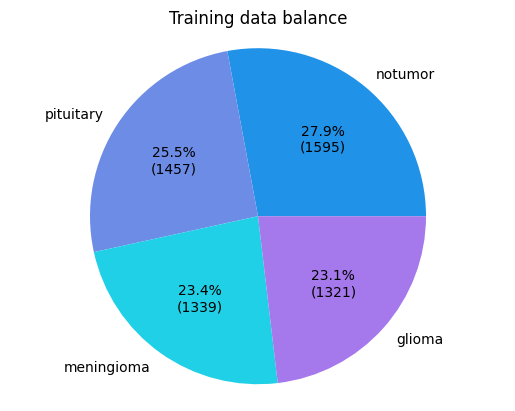

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: labels, dtype: int64

In [ ]:
data_balance = tr_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct,
        colors = ["#2092E8","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()
data_balance

In [ ]:
valid_df,tst_df=train_test_split(ts_df,test_size=0.5,random_state=50,stratify=ts_df["labels"])
print(f"ts_df shape: {ts_df.shape}")
print("---"*10)
print(f"valid data shape: {valid_df.shape}")
print(f"test data shape: {tst_df.shape}")

ts_df shape: (1311, 2)
------------------------------
valid data shape: (655, 2)
test data shape: (656, 2)


In [ ]:
img_size=(224,224)

tr=ImageDataGenerator()
ts=ImageDataGenerator()

train_gen=tr.flow_from_dataframe(tr_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=16,shuffle=True,
                                 class_mode='categorical',color_mode="rgb")


valid_gen=ts.flow_from_dataframe(ts_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="rgb",
                                 shuffle=True,batch_size=16,)


test_gen=ts.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=16, shuffle=False,
                                 color_mode="rgb", class_mode="categorical")

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


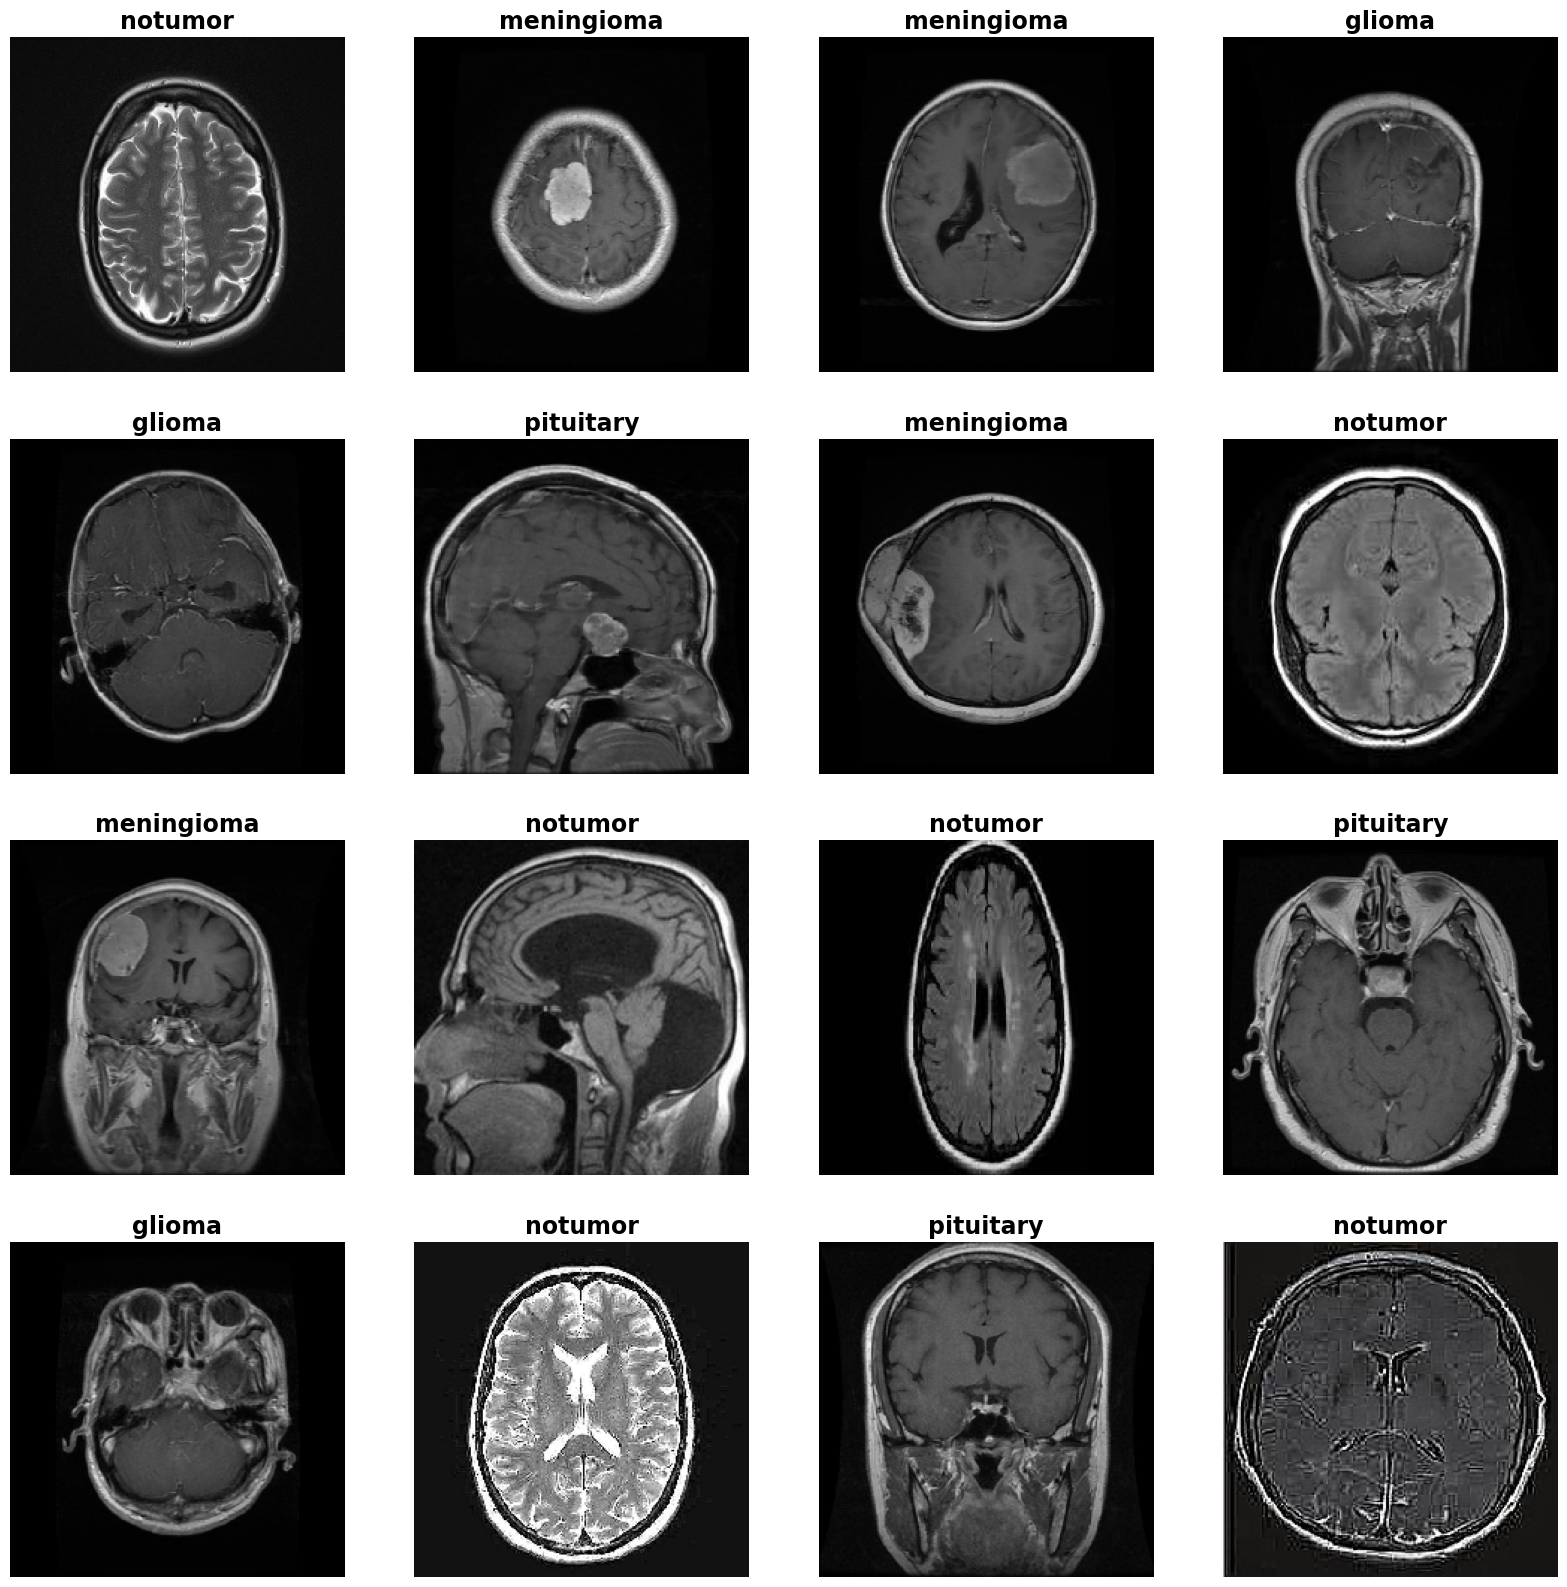

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 17,weight="bold")
    plt.axis('off')
plt.show()

In [ ]:
img_shape=(224,224,3)
base_Model = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= img_shape, pooling= 'max')

Model = Sequential([
    base_Model,
    Dropout(rate= 0.5),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

Model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

Model.summary()

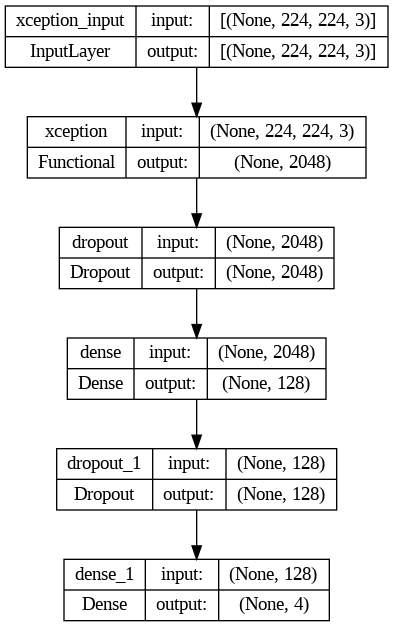

In [ ]:
tf.keras.utils.plot_model(Model,show_shapes=True)

In [ ]:
historyy=Model.fit(train_gen,epochs=10,
                  validation_data=valid_gen,
                  shuffle=False)

In [ ]:
model_json = Model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
Model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
historyy.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 2000x800 with 0 Axes>

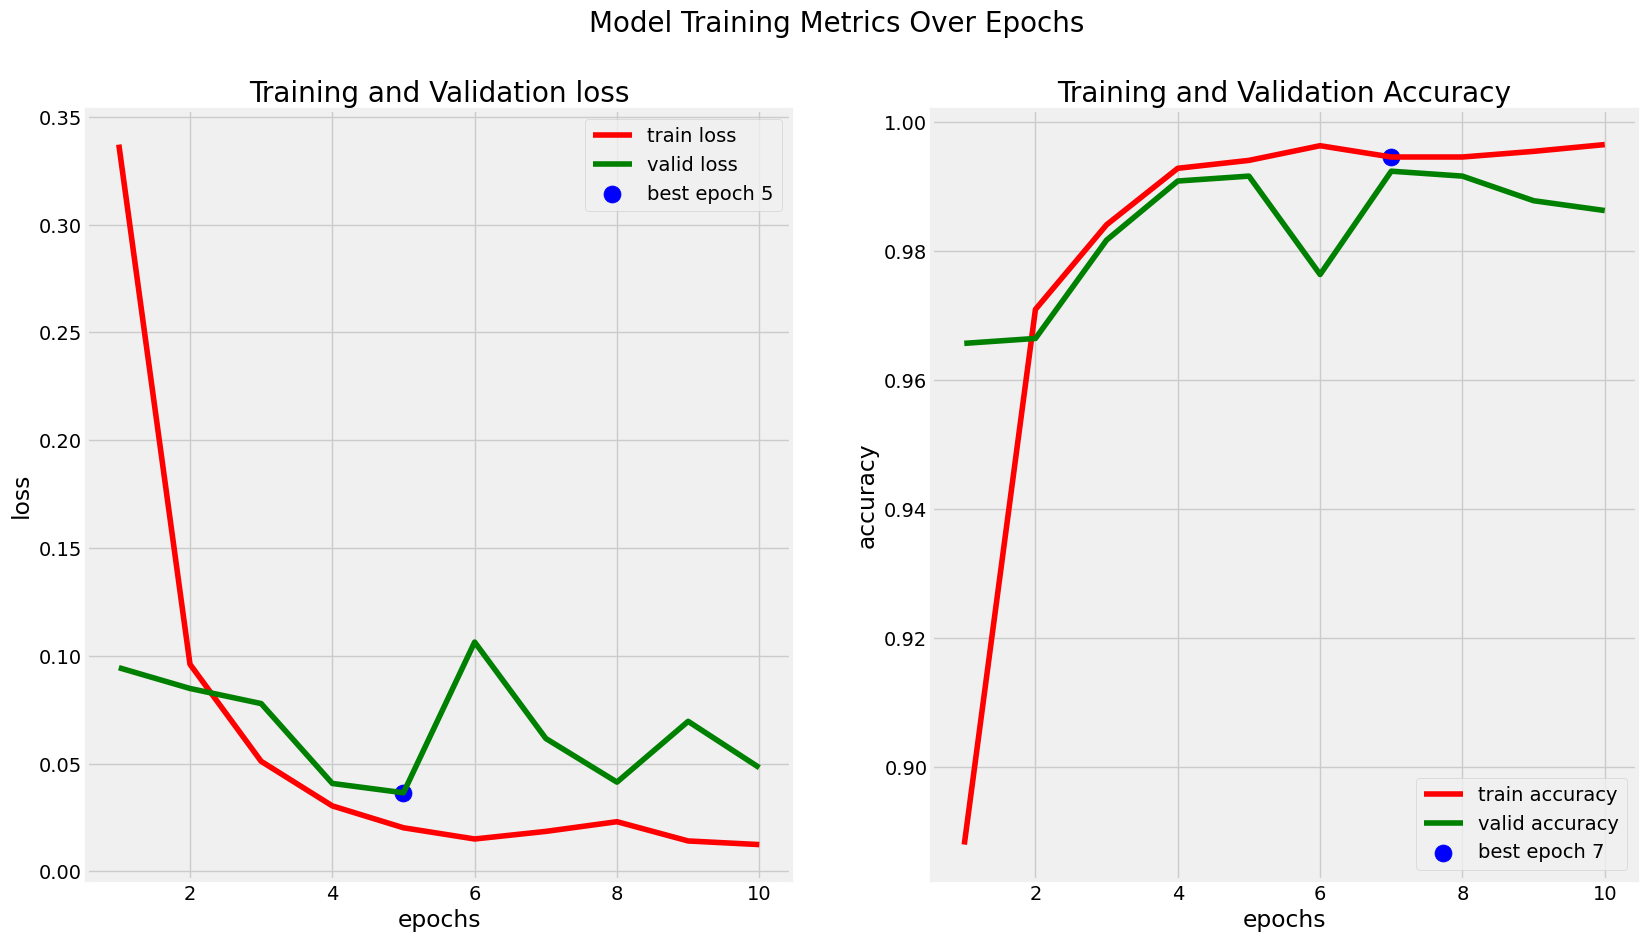

In [ ]:
plt.figure(figsize=(20, 8))
tr_loss=historyy.history["loss"]
val_loss=historyy.history["val_loss"]
index_loss=np.argmin(val_loss)
loss_lowest=val_loss[index_loss]
l_label=f"best epoch {index_loss+1}"

tr_accuracy=historyy.history["accuracy"]
val_accuracy=historyy.history["val_accuracy"]
index_acc=np.argmax(val_accuracy)
acc_highest=tr_accuracy[index_acc]
c_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(tr_accuracy))]


plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs,tr_loss,"r",label="train loss")
plt.plot(epochs,val_loss,"g",label="valid loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=l_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs,tr_accuracy,"r",label="train accuracy")
plt.plot(epochs,val_accuracy,"g",label="valid accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=c_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Model Training Metrics Over Epochs', fontsize=20);

In [ ]:
train_score=Model.evaluate(train_gen)
valid_score=Model.evaluate(valid_gen)
test_score=Model.evaluate(test_gen)

print(f"Train Loss : {train_score[0]:.3f}")
print(f"Train Accuracy : {train_score[1]*100:.2f}%")
print("-"*20)
print(f"Validation Loss : {valid_score[0]:.3f}")
print(f"Validation Accuracy : {valid_score[1]*100:.2f}%")
print("-"*20)
print(f"Test Loss: {test_score[0]:.3f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

In [ ]:
preds=Model.predict(test_gen)
y_pred=np.argmax(preds,axis=1)

82/82 [==============================] - 6s 67ms/step


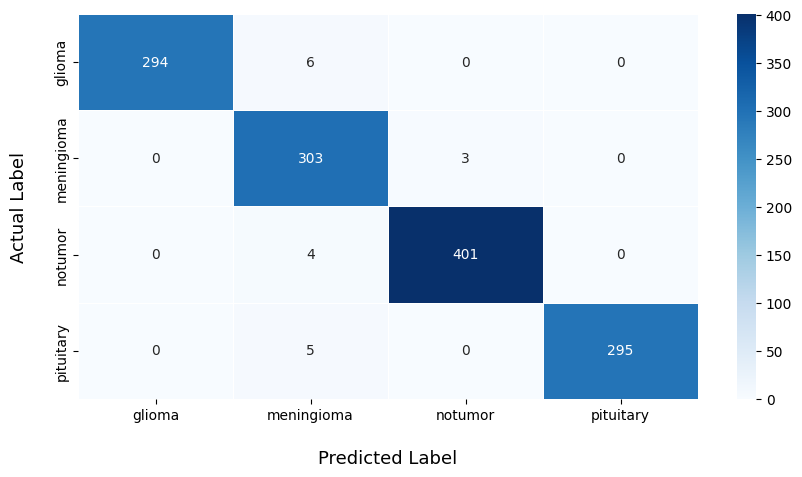

In [ ]:
plt.figure(figsize=(10,5))
plt.style.use('default')
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [ ]:
cr=classification_report(test_gen.classes,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       300
           1       0.95      0.99      0.97       306
           2       0.99      0.99      0.99       405
           3       1.00      0.98      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
import json

import numpy as np
import torch
import torchvision

import shap

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!ls -l model.h5

In [ ]:
!file model.h5

In [ ]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21069740 (80.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________
